# Imports

In [1]:
import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import clear_output
%matplotlib inline

/Users/JordanVani/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Functions

In [2]:
def ts_matrix(df, dur):
    """Create matrix of all cameras' mean time series.
    df - dataframe containing pedestrian counts.
    dur - time interval to resample (e.g., '1Min')."""
    
    ts = []
    # -- Sort time series' by mean value & return resampled time series.
    for idx, cam in enumerate(df.groupby("cam_id").mean().sort_values("count", ascending=False).index):
        print "Camera: {} ({}/{})".format(cam, idx, len(df.cam_id.unique()))
        clear_output(wait=True)
        ts.append(resample_min(df[df.cam_id == cam], cam, dur))
    return pd.concat(ts, axis=1).T

def resample_min(df, col_name, dur):
    """Calculate mean time series by time interval 'dur'.
    df - dataframe containing pedestrian counts.
    col_name - resulting column name.
    dur - time interval to resample (e.g., '1Min')."""
    
    temp = df.copy()
    temp.index = map(lambda x: pd.datetime.combine(datetime.datetime.today(), x),
                     temp["date"].dt.time)
    temp = temp.resample(dur, level=0).mean()[["count"]]
    temp.columns = [str(col_name)]
    return temp

def sif_schedule(csv_path):
    """Read in SI ferry schedule and convert to datetime."""
    df = pd.read_csv(csv_path, names=["AM", "PM"], header=0).dropna()
    df.AM, df.PM = df.AM + " AM", df.PM + " PM"
    df = pd.DataFrame(pd.concat([df.AM, df.PM]), columns=["t"]).reset_index(drop=True)
    df["dep"] =  pd.to_datetime(pd.datetime.today().date().strftime("%Y-%m-%d ") + df["t"])
    return df

# Load Data

In [3]:
counts = pd.read_csv("../data/external/hadive-data.csv",
                 usecols=["cam_id", "date", "cam_dir", "count", "imtime"],
                 dtype={"cam_id": int, "date": str, "cam_dir": str,
                        "count": int, "imtime": str}, parse_dates=["date"],
                 infer_datetime_format=True, index_col="date")
counts.head(2)

,cam_id,cam_dir,count,imtime
date,,,,
2017-06-27 20:09:22,368,S,1,NaN
2017-06-27 20:09:23,360,NaN,1,NaN


In [4]:
cams = pd.read_csv("../data/external/cameras.csv")
cams.head(2)

,cam_id,cctv_id,description,lat,long,people,ribbon,boro,zipcode
0,112,83,SIE @ Richmond Ave,40.614885,-74.157435,0.0,1.0,Staten Island,10314
1,121,129,LIE @ Kissena Blvd,40.738943,-73.815047,1.0,0.0,Queens,11367


In [5]:
df = counts[["cam_id", "count"]].reset_index() \
        .merge(cams[cams["people"] == 1.][["cam_id", "boro"]])
df.head(2)

,date,cam_id,count,boro
0,2017-06-27 20:09:22,368,1,Manhattan
1,2017-06-27 20:10:39,368,1,Manhattan


In [6]:
si_wd = sif_schedule("../data/external/si_ferry_weekday_si_departures.csv")
si_we = sif_schedule("../data/external/si_ferry_weekend_si_departures.csv")
print si_wd.dtypes
si_wd.head(2)

t              object
dep    datetime64[ns]
dtype: object


,t,dep
0,12:00 AM,2017-09-11 00:00:00
1,12:30 AM,2017-09-11 00:30:00


# Periodicity @ Camera 985

In [7]:
cam_wd = ts_matrix(df[(df.cam_id == 985) & (df.date.dt.weekday < 5)], "1Min").T
cam_wd_std = (cam_wd - cam_wd.mean()) / cam_wd.std()
cam_we = ts_matrix(df[(df.cam_id == 985) & (df.date.dt.weekday >= 5)], "1Min").T
cam_we_std = (cam_we - cam_we.mean()) / cam_we.std()

Camera: 985 (0/1)


[('cam_id', 985), ('cctv_id', '873'), ('description', 'Water St @ Whitehall')]


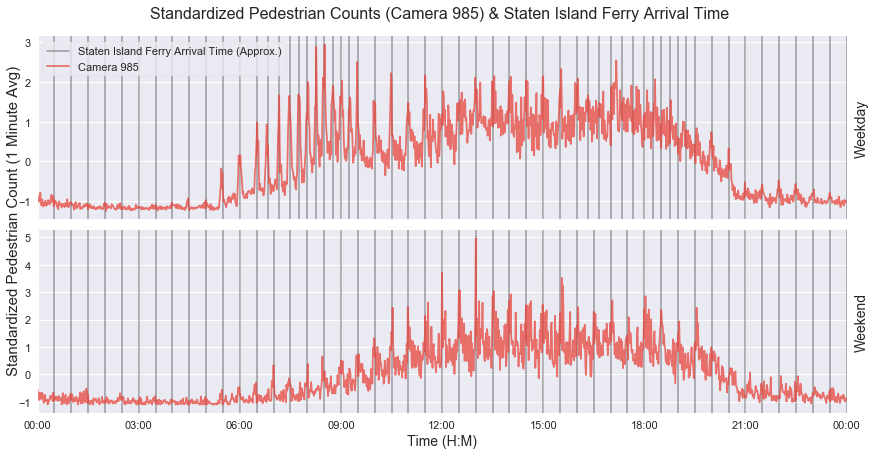

In [8]:
print zip(cams.columns[:3], cams[cams.cam_id == 985].values[0][:3])
fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))

# -- Plot vertical lines for each SI ferry departure time.
for dep in si_wd.dep:
    ax1.axvline(x=dep + pd.Timedelta("30 min"), color="k", alpha=0.3, label="Arrival Time")
for dep in si_we.dep:
    ax2.axvline(x=dep + pd.Timedelta("30 min"), color="k", alpha=0.3)   

# -- Standardize mean weekday timeseries & plot.
l1 = cam_wd_std.plot(c="#e83a30", alpha=0.7, ax=ax1)
l2 = cam_we_std.plot(c="#e83a30", alpha=0.7, ax=ax2)

# -- Plot formatting.
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[-2:], ["Staten Island Ferry Arrival Time (Approx.)", "Camera 985"], 
           loc="upper left", fontsize=11, frameon=True)
ax1.set_xticklabels([])
ax2.legend().remove()
ax2.set_xlabel("Time (H:M)", fontsize=14)
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.xticks(rotation=0, ha="center")
for (ax, txt) in [(ax1, "Weekday"), (ax2, "Weekend")]:
    ax.tick_params(axis="both", which="both", labelsize=11)
    ax.text(1.01, 0.5, txt, fontsize=14, rotation=90, va="center", 
             transform=ax.transAxes)
fig.text(0, 0.55, "Standardized Pedestrian Count (1 Minute Avg)", 
         rotation=90, va="center", fontsize=15)
fig.suptitle("Standardized Pedestrian Counts (Camera 985) & Staten Island Ferry Arrival Time",
             fontsize=16, va="bottom", y=1.01)
fig.tight_layout()